# Use Adam till convergence point then use SGDM

In [1]:
!pip install wandb==0.9.7
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 8fce5ee4a321acdc93b1ab718535a737dc60ad84
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image
import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Import dataset

In [3]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [5]:
def train(model, train_loader, optimizer, loss_func, epochs=30):
    accuracy_lst_train = []
    loss_lst_train = []
    accuracy_lst_val = []
    loss_lst_val = []
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        model.train()
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst_train.append((correct/num_labels).cpu().item())
        loss_lst_train.append(total_loss/counter)

        # Validation
        model.eval()
        total_loss_val = 0
        correct_val = 0
        num_labels_val = 0
        counter_val = 0
        model.eval()
        for batch_idx, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)

            output = model(X)

            loss = loss_func(output, y)
            total_loss_val += loss.item()

            predicted = torch.max(output,1)[1]
            correct_val += (predicted == y).sum()
            num_labels_val += len(y)
            counter_val += 1
        loss_lst_val.append(total_loss_val/counter_val)
        accuracy_lst_val.append((correct_val/num_labels_val).cpu().item())

        # Log
        wandb.log({'Training Accuracy': accuracy_lst_train[-1], 'Training Loss': loss_lst_train[-1], 'Testing Accuracy': accuracy_lst_val[-1], 'Testing Loss': loss_lst_val[-1]})

        print('Epoch %d, Training Loss %4f, Training Accuracy %4f, Testing Loss %4f, Testing Accuracy %4f'
            % (epoch+1, total_loss/counter, correct/num_labels, total_loss_val/counter_val, correct_val/num_labels_val))
    return accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val

## Training

In [6]:
lr = 0.001

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=10, bias=True)
)


### SGDM

In [7]:
num_epoch = 60

In [8]:

optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.95, weight_decay=5e-4)
Adam_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='SGDAdam')
wandb.watch(model, log="all", log_freq=10)
accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val = train(model, train_loader, optimizer, loss_func, num_epoch)

wandb: Wandb version 0.13.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training progress:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60:   0%|          | 0/196 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 1, Training Loss 1.670010, Training Accuracy 0.396340, Testing Loss 1.398276, Testing Accuracy 0.509500


Epoch 2/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Training Loss 1.357916, Training Accuracy 0.514420, Testing Loss 1.364339, Testing Accuracy 0.534400


Epoch 3/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Training Loss 1.248008, Training Accuracy 0.559780, Testing Loss 1.157901, Testing Accuracy 0.593400


Epoch 4/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Training Loss 1.165276, Training Accuracy 0.589100, Testing Loss 1.228665, Testing Accuracy 0.574800


Epoch 5/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Training Loss 1.106053, Training Accuracy 0.614280, Testing Loss 1.283336, Testing Accuracy 0.543100


Epoch 6/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Training Loss 1.065827, Training Accuracy 0.629400, Testing Loss 0.995416, Testing Accuracy 0.646200


Epoch 7/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Training Loss 1.045919, Training Accuracy 0.636580, Testing Loss 1.015471, Testing Accuracy 0.647400


Epoch 8/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Training Loss 1.003576, Training Accuracy 0.650640, Testing Loss 0.979996, Testing Accuracy 0.661300


Epoch 9/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.981192, Training Accuracy 0.660300, Testing Loss 0.998692, Testing Accuracy 0.653400


Epoch 10/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.956819, Training Accuracy 0.669360, Testing Loss 0.937286, Testing Accuracy 0.678600


Epoch 11/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.938889, Training Accuracy 0.675220, Testing Loss 0.991937, Testing Accuracy 0.659600


Epoch 12/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.918442, Training Accuracy 0.683580, Testing Loss 0.921500, Testing Accuracy 0.675800


Epoch 13/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.900080, Training Accuracy 0.689920, Testing Loss 0.868440, Testing Accuracy 0.699600


Epoch 14/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.880112, Training Accuracy 0.693780, Testing Loss 0.907017, Testing Accuracy 0.689400


Epoch 15/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.870477, Training Accuracy 0.699320, Testing Loss 0.965735, Testing Accuracy 0.666200


Epoch 16/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.851983, Training Accuracy 0.705760, Testing Loss 1.084378, Testing Accuracy 0.633400


Epoch 17/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.846780, Training Accuracy 0.707560, Testing Loss 0.993879, Testing Accuracy 0.662900


Epoch 18/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.832147, Training Accuracy 0.714700, Testing Loss 0.825038, Testing Accuracy 0.722100


Epoch 19/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.822341, Training Accuracy 0.717620, Testing Loss 0.857951, Testing Accuracy 0.707900


Epoch 20/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.813397, Training Accuracy 0.721380, Testing Loss 0.798511, Testing Accuracy 0.724200


Epoch 21/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.806406, Training Accuracy 0.720820, Testing Loss 0.868064, Testing Accuracy 0.704600


Epoch 22/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.788187, Training Accuracy 0.731120, Testing Loss 0.984649, Testing Accuracy 0.661100


Epoch 23/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.790561, Training Accuracy 0.728040, Testing Loss 0.823660, Testing Accuracy 0.719800


Epoch 24/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.773971, Training Accuracy 0.735040, Testing Loss 0.800000, Testing Accuracy 0.734700


Epoch 25/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.770840, Training Accuracy 0.736960, Testing Loss 0.802279, Testing Accuracy 0.726500


Epoch 26/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.765841, Training Accuracy 0.736760, Testing Loss 0.907141, Testing Accuracy 0.693800


Epoch 27/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.762354, Training Accuracy 0.737840, Testing Loss 0.985430, Testing Accuracy 0.668800


Epoch 28/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.747046, Training Accuracy 0.742920, Testing Loss 0.823594, Testing Accuracy 0.721900


Epoch 29/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.748426, Training Accuracy 0.742640, Testing Loss 0.743658, Testing Accuracy 0.747500


Epoch 30/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Training Loss 0.743225, Training Accuracy 0.745700, Testing Loss 0.817278, Testing Accuracy 0.722900


Epoch 31/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.730527, Training Accuracy 0.750140, Testing Loss 0.829374, Testing Accuracy 0.718500


Epoch 32/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.719668, Training Accuracy 0.753660, Testing Loss 0.820121, Testing Accuracy 0.724100


Epoch 33/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.725236, Training Accuracy 0.750800, Testing Loss 0.852846, Testing Accuracy 0.719100


Epoch 34/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.715804, Training Accuracy 0.755560, Testing Loss 0.827134, Testing Accuracy 0.719200


Epoch 35/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.708850, Training Accuracy 0.756640, Testing Loss 0.846736, Testing Accuracy 0.709200


Epoch 36/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.704663, Training Accuracy 0.757800, Testing Loss 0.705410, Testing Accuracy 0.760100


Epoch 37/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.697422, Training Accuracy 0.762700, Testing Loss 0.748244, Testing Accuracy 0.741200


Epoch 38/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.696660, Training Accuracy 0.762480, Testing Loss 0.866157, Testing Accuracy 0.705300


Epoch 39/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.693239, Training Accuracy 0.763740, Testing Loss 0.868455, Testing Accuracy 0.708200


Epoch 40/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Training Loss 0.695522, Training Accuracy 0.762600, Testing Loss 0.813252, Testing Accuracy 0.722700


Epoch 41/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Training Loss 0.682495, Training Accuracy 0.767720, Testing Loss 0.749082, Testing Accuracy 0.745100


Epoch 42/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Training Loss 0.675977, Training Accuracy 0.769680, Testing Loss 0.832259, Testing Accuracy 0.721000


Epoch 43/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Training Loss 0.675856, Training Accuracy 0.767400, Testing Loss 0.757283, Testing Accuracy 0.748600


Epoch 44/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Training Loss 0.670388, Training Accuracy 0.769940, Testing Loss 0.988009, Testing Accuracy 0.669900


Epoch 45/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Training Loss 0.674369, Training Accuracy 0.770660, Testing Loss 0.659612, Testing Accuracy 0.771500


Epoch 46/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Training Loss 0.668372, Training Accuracy 0.770740, Testing Loss 0.679455, Testing Accuracy 0.769300


Epoch 47/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Training Loss 0.662934, Training Accuracy 0.775160, Testing Loss 0.693971, Testing Accuracy 0.763600


Epoch 48/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Training Loss 0.666743, Training Accuracy 0.772320, Testing Loss 0.741130, Testing Accuracy 0.754400


Epoch 49/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Training Loss 0.656460, Training Accuracy 0.774900, Testing Loss 0.824666, Testing Accuracy 0.722300


Epoch 50/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Training Loss 0.656296, Training Accuracy 0.777280, Testing Loss 0.751300, Testing Accuracy 0.750200


Epoch 51/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Training Loss 0.651477, Training Accuracy 0.777700, Testing Loss 0.796749, Testing Accuracy 0.733400


Epoch 52/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Training Loss 0.648166, Training Accuracy 0.779520, Testing Loss 0.745576, Testing Accuracy 0.749700


Epoch 53/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Training Loss 0.644153, Training Accuracy 0.778040, Testing Loss 0.730475, Testing Accuracy 0.754100


Epoch 54/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Training Loss 0.645993, Training Accuracy 0.778720, Testing Loss 0.843747, Testing Accuracy 0.724100


Epoch 55/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Training Loss 0.635273, Training Accuracy 0.780900, Testing Loss 0.731323, Testing Accuracy 0.753900


Epoch 56/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Training Loss 0.644507, Training Accuracy 0.780200, Testing Loss 0.766916, Testing Accuracy 0.749000


Epoch 57/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Training Loss 0.640300, Training Accuracy 0.779720, Testing Loss 0.741720, Testing Accuracy 0.755500


Epoch 58/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Training Loss 0.632777, Training Accuracy 0.784100, Testing Loss 0.752400, Testing Accuracy 0.740000


Epoch 59/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Training Loss 0.633774, Training Accuracy 0.781900, Testing Loss 0.687383, Testing Accuracy 0.772200


Epoch 60/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60, Training Loss 0.633980, Training Accuracy 0.783140, Testing Loss 0.742930, Testing Accuracy 0.750400


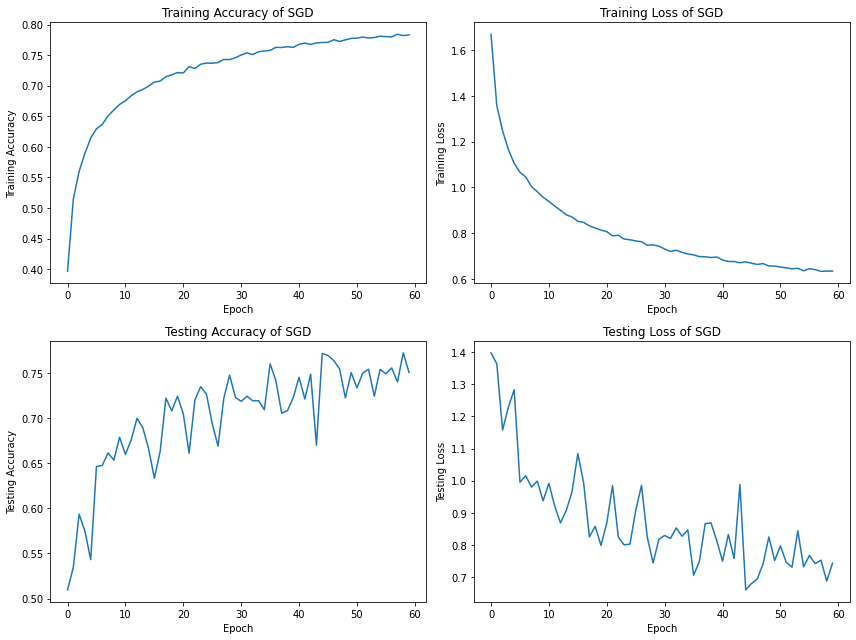

In [9]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(num_epoch), accuracy_lst_train)
axs[0, 0].set_title('Training Accuracy of SGD')
axs[0, 0].set(xlabel='Epoch', ylabel='Training Accuracy')

axs[0, 1].plot(range(num_epoch), loss_lst_train)
axs[0, 1].set_title('Training Loss of SGD')
axs[0, 1].set(xlabel='Epoch', ylabel='Training Loss')

axs[1, 0].plot(range(num_epoch), accuracy_lst_val)
axs[1, 0].set_title('Testing Accuracy of SGD')
axs[1, 0].set(xlabel='Epoch', ylabel='Testing Accuracy')

axs[1, 1].plot(range(num_epoch), loss_lst_val)
axs[1, 1].set_title('Testing Loss of SGD')
axs[1, 1].set(xlabel='Epoch', ylabel='Testing Loss')

fig.set_size_inches(12, 9)
fig.tight_layout()

### Adam

In [10]:
num_epoch = 40

In [ ]:
# Adam
# Adam_run = wandb.init(project="CSI 5340 Project", entity="kwang126", name='AdamSGD')
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)

accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val = train(model, train_loader, optimizer, loss_func, num_epoch)

Adam_run.finish()

Training progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40:   0%|          | 0/196 [00:00<?, ?it/s]

wandb: Wandb version 0.13.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1, Training Loss 0.749730, Training Accuracy 0.744480, Testing Loss 0.806206, Testing Accuracy 0.727500


Epoch 2/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Training Loss 0.728136, Training Accuracy 0.749100, Testing Loss 2.013207, Testing Accuracy 0.530800


Epoch 3/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Training Loss 0.707327, Training Accuracy 0.754760, Testing Loss 0.966129, Testing Accuracy 0.693900


Epoch 4/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Training Loss 0.713113, Training Accuracy 0.753840, Testing Loss 0.835397, Testing Accuracy 0.718400


Epoch 5/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Training Loss 0.686621, Training Accuracy 0.762540, Testing Loss 0.763013, Testing Accuracy 0.744500


Epoch 6/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.692276, Training Accuracy 0.761160, Testing Loss 0.784196, Testing Accuracy 0.744500


Epoch 7/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.682908, Training Accuracy 0.764460, Testing Loss 0.752541, Testing Accuracy 0.750600


Epoch 8/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.680199, Training Accuracy 0.767080, Testing Loss 0.734228, Testing Accuracy 0.749900


Epoch 9/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.683476, Training Accuracy 0.764380, Testing Loss 0.789829, Testing Accuracy 0.734000


Epoch 10/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.663514, Training Accuracy 0.772180, Testing Loss 0.884453, Testing Accuracy 0.719300


Epoch 11/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.663906, Training Accuracy 0.771060, Testing Loss 0.737372, Testing Accuracy 0.753100


Epoch 12/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.660853, Training Accuracy 0.772900, Testing Loss 0.733024, Testing Accuracy 0.746900


Epoch 13/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.666288, Training Accuracy 0.770120, Testing Loss 0.928246, Testing Accuracy 0.691200


Epoch 14/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.650011, Training Accuracy 0.775800, Testing Loss 0.916069, Testing Accuracy 0.707700


Epoch 15/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.643612, Training Accuracy 0.778840, Testing Loss 0.701227, Testing Accuracy 0.759300


Epoch 16/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.648834, Training Accuracy 0.775720, Testing Loss 0.749857, Testing Accuracy 0.752000


Epoch 17/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.636038, Training Accuracy 0.780360, Testing Loss 0.734807, Testing Accuracy 0.751900


Epoch 18/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.633682, Training Accuracy 0.782340, Testing Loss 0.749113, Testing Accuracy 0.751900


Epoch 19/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.628448, Training Accuracy 0.783660, Testing Loss 0.649690, Testing Accuracy 0.777000


Epoch 20/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.634826, Training Accuracy 0.782120, Testing Loss 0.962862, Testing Accuracy 0.698200


Epoch 21/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.636539, Training Accuracy 0.780200, Testing Loss 0.754566, Testing Accuracy 0.746600


Epoch 22/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.624661, Training Accuracy 0.784080, Testing Loss 0.948527, Testing Accuracy 0.698400


Epoch 23/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.621779, Training Accuracy 0.784720, Testing Loss 0.740868, Testing Accuracy 0.750700


Epoch 24/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.611384, Training Accuracy 0.790740, Testing Loss 0.712471, Testing Accuracy 0.756200


Epoch 25/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.616630, Training Accuracy 0.784880, Testing Loss 0.813718, Testing Accuracy 0.738800


Epoch 26/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.612383, Training Accuracy 0.789700, Testing Loss 0.954628, Testing Accuracy 0.695500


Epoch 27/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.607380, Training Accuracy 0.792120, Testing Loss 0.629442, Testing Accuracy 0.787600


Epoch 28/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.606076, Training Accuracy 0.791160, Testing Loss 0.706718, Testing Accuracy 0.765800


Epoch 29/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.611356, Training Accuracy 0.790800, Testing Loss 0.716823, Testing Accuracy 0.765600


Epoch 30/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Training Loss 0.603303, Training Accuracy 0.792860, Testing Loss 0.769538, Testing Accuracy 0.743400


Epoch 31/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.597160, Training Accuracy 0.794940, Testing Loss 0.635802, Testing Accuracy 0.778900


Epoch 32/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.596441, Training Accuracy 0.795540, Testing Loss 0.694531, Testing Accuracy 0.764600


Epoch 33/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.605231, Training Accuracy 0.792700, Testing Loss 0.691767, Testing Accuracy 0.766700


Epoch 34/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.593459, Training Accuracy 0.795900, Testing Loss 0.765970, Testing Accuracy 0.749700


Epoch 35/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.589594, Training Accuracy 0.796580, Testing Loss 0.683607, Testing Accuracy 0.770300


Epoch 36/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.588733, Training Accuracy 0.796720, Testing Loss 0.725627, Testing Accuracy 0.755500


Epoch 37/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.589098, Training Accuracy 0.795960, Testing Loss 0.659709, Testing Accuracy 0.775500


Epoch 38/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.585750, Training Accuracy 0.799060, Testing Loss 0.719846, Testing Accuracy 0.769600


Epoch 39/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.582964, Training Accuracy 0.800240, Testing Loss 0.637898, Testing Accuracy 0.785100


Epoch 40/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Training Loss 0.582045, Training Accuracy 0.800000, Testing Loss 0.669032, Testing Accuracy 0.771800


In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(num_epoch), accuracy_lst_train)
axs[0, 0].set_title('Training Accuracy of Adam')
axs[0, 0].set(xlabel='Epoch', ylabel='Training Accuracy')

axs[0, 1].plot(range(num_epoch), loss_lst_train)
axs[0, 1].set_title('Training Loss of Adam')
axs[0, 1].set(xlabel='Epoch', ylabel='Training Loss')

axs[1, 0].plot(range(num_epoch), accuracy_lst_val)
axs[1, 0].set_title('Testing Accuracy of Adam')
axs[1, 0].set(xlabel='Epoch', ylabel='Testing Accuracy')

axs[1, 1].plot(range(num_epoch), loss_lst_val)
axs[1, 1].set_title('Testing Loss of Adam')
axs[1, 1].set(xlabel='Epoch', ylabel='Testing Loss')

fig.set_size_inches(12, 9)
fig.tight_layout()